## Model

In [1]:
name = 'ResNN_329'
batch_size = 128
model_basename = 'ResNN4'
train_steps = 20000
import sys; sys.argv=['', 
                      '--log_dir', '/nfs/P100/DSC/log/%s'%name, 
                      '--model_dir', '/nfs/P100/DSC/model/%s'%name, 
                      '--batch_size', '%d'%batch_size,
                      '--model_basename', model_basename,
                      '--train_steps', '%d'%train_steps,
                      '--learning_rate', '1e-4',
                      '--Is_BN', 'True',
                      '--weight_decay','5e-6',
                     ];
del sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow as tf
import numpy as np
import tqdm
tf.logging.set_verbosity(tf.logging.INFO)

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from tftool.main import Main

In [4]:
class RunWapper(Main):
    def __init__(self, *args, **kwargs):
        super(RunWapper, self).__init__(*args, **kwargs)
        self.data_shape = 4801
    def __call__(self):
        """an example for constructing network model"""
        self.train_filenames = ["/nfs/P100/DSC/data/1218/training.tfrecords"]
        self.valid_filenames = ["/nfs/P100/DSC/data/1218/valid.tfrecords"]
        self.Is_training = tf.placeholder(tf.bool,shape=[],name='is_train')
        x, y_ = self.loaddata(shuffle=True)
        net = self.inference(x, is_training=self.Is_training)
        loss = self.Loss_fn(self, net=net, y_=y_)
        train_op = self.optimizer(loss, gclip=1.0)
        self.train(loss, train_op)  
    
    def eval(self, flux, label):
        BS = self.FLAGS.batch_size
        label = label.astype(np.int32)
        print flux.dtype, flux.shape
        print label.dtype, label.shape
        if label.shape[0]%BS == 0:
            loop_num = label.shape[0]//BS
        else:
            loop_num = label.shape[0]//BS + 1
        print "loop number: %d"%loop_num
        #------------------------------------------------------------
        x = tf.placeholder(tf.float32, shape=[None, self.data_shape])
        y_ = tf.placeholder(tf.int32, shape=[None])
        net = self.inference(x, is_training=False)
        loss = self.Loss_fn(self, net=net, y_=y_)
        prob = tf.get_collection('prob')[0]
        LOSS = []
        PROB = []
        with tf.Session(config=self.config) as sess:
            self.Saver = tf.train.Saver(max_to_keep=1)
            self.init_model(sess)
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            for i in tqdm.tqdm(xrange(loop_num)):
                el, ep, = sess.run([loss, prob], 
                                   feed_dict={x:flux[i*BS:(i+1)*BS],
                                              y_:label[i*BS:(i+1)*BS]})
                LOSS.append(el)
                PROB.append(ep)
            coord.request_stop()
            coord.join(threads)
        LOSS = np.array(LOSS)
        PROB = np.vstack(PROB)
        return LOSS, PROB
dsc = RunWapper()
print dsc.FLAGS

INFO:tensorflow:(<class 'tftool.main.Main'>, <class 'tftool.Train.Train'>, <class 'tftool.Network.Model'>, <class 'tftool.InputPipeline.InputPipeline'>, <class 'tftool.Utils.Toolkit'>, <class 'tftool.Base.Base'>, <type 'object'>)
Namespace(Is_BN=True, batch_size=128, learning_rate=0.0001, log_dir='/nfs/P100/DSC/log/ResNN_329', model_basename='ResNN4', model_dir='/nfs/P100/DSC/model/ResNN_329', train_steps=20000, weight_decay=5e-06)


In [5]:
config = tf.ConfigProto(allow_soft_placement=True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
config.gpu_options.allow_growth = True
dsc.opt = tf.train.AdamOptimizer
#dsc.opt = tf.train.GradientDescentOptimizer
dsc.Is_summary = True
dsc.update_log_step =100
dsc.save_per_steps = 1000
dsc.print_log = False 
dsc.valid_size = 6144
dsc.config = config

### training

In [6]:
dsc()

INFO:tensorflow:Tensor("InputPipeline/input_fn/IteratorGetNext:0", shape=(?, 4801), dtype=float32)
INFO:tensorflow:==========ResNet_sigmoid==========
INFO:tensorflow:load variable from /nfs/P100/DSC/model/ResNN_329/ResNN4-5999
INFO:tensorflow:Restoring parameters from /nfs/P100/DSC/model/ResNN_329/ResNN4-5999


  3%|▎         | 600/20000 [00:32<15:58, 20.24it/s]

epoch 1: 0.320394


  7%|▋         | 1400/20000 [01:12<15:14, 20.35it/s]

epoch 2: 0.325689


 11%|█         | 2200/20000 [01:52<14:35, 20.33it/s]

epoch 3: 0.329543


KeyboardInterrupt: 

 11%|█         | 2200/20000 [02:10<14:35, 20.33it/s]

---
## Evaluation

In [6]:
data_test = np.load('/nfs/P100/DSC/data/1218/test.npy')
norm_arr = np.load('/nfs/P100/DSC/data/1218/train_mean_std.npy')
data_test['flux_norm'] = (data_test['flux_norm'] - norm_arr[:,0]) / norm_arr[:,1]

In [7]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [8]:
loss, prob = dsc.eval(data_test['flux_norm'], data_test['label'])

float32 (6411, 4801)
int32 (6411,)
loop number: 51
INFO:tensorflow:Tensor("Placeholder:0", shape=(?, 4801), dtype=float32)
INFO:tensorflow:==========ResNet_sigmoid==========
INFO:tensorflow:load variable from /nfs/P100/DSC/model/ResNN_329/ResNN4-5999
INFO:tensorflow:Restoring parameters from /nfs/P100/DSC/model/ResNN_329/ResNN4-5999


100%|██████████| 51/51 [00:02<00:00, 17.94it/s]


In [9]:
import matplotlib.pyplot as plt
params = {
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5],
    #----------
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'image.cmap': 'jet',
    'legend.frameon':  False,
    'xtick.top': True,
    'ytick.right': True,
    #----------
    'lines.linewidth': 2.0,
#    'axes.labelsize': 12,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.minor.top': True, 
    'xtick.minor.bottom': True, 
    'ytick.minor.left': True, 
    'ytick.minor.right': True,
   }
plt.rcParams.update(params)

0.3093154
| class | percentage | 
|-------|-------|
| d -> d | 0.04929028232725004  | 
| s -> s | 0.8338792700046794  | 
| d -> s | 0.007175167680549056  | 
| s -> d | 0.10965527998752145  | 


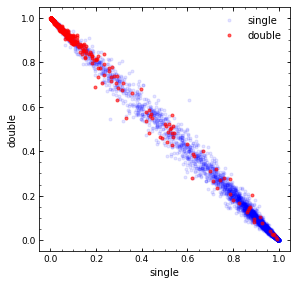

/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


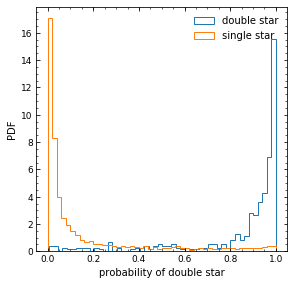

In [10]:
plt.rcParams.update(params)
print loss.mean()
threshold_d = 0.5
threshold_s = 0.5
bool_gt = data_test['label']
bool_es = (prob[:,1]>threshold_d) * (prob[:,0]<threshold_s)
size_eval = data_test.shape[0]
bool_dd = bool_gt*bool_es
bool_ss = (1-bool_gt)*(1-bool_es)
bool_ds = bool_gt*(1-bool_es)
bool_sd = (1-bool_gt)*bool_es
print '| class | percentage |', '\n|-------|-------|'
print '| d -> d |', np.sum(bool_dd)/float(size_eval), ' | ' # d -> d
print '| s -> s |', np.sum(bool_ss)/float(size_eval), ' | '  # s -> s
print '| d -> s |', np.sum(bool_ds)/float(size_eval), ' | '  # d -> s
print '| s -> d |', np.sum(bool_sd)/float(size_eval), ' | '  # s -> d

plt.plot(prob[bool_gt==0][:,0], prob[bool_gt==0][:,1], 'b.', label='single', alpha=0.1)
plt.plot(prob[bool_gt==1][:,0], prob[bool_gt==1][:,1], 'r.', label='double', alpha=0.6)
plt.xlabel('single')
plt.ylabel('double')
plt.legend()
plt.show()

plt.hist(prob[bool_gt==1][:,1], 50, normed=True, histtype='step', label='double star')
plt.hist(prob[bool_gt==0][:,1], 50, normed=True, histtype='step', label='single star')
plt.xlabel('probability of double star')
plt.ylabel('PDF')
plt.legend()
plt.savefig('./test/%s_test.png'%(mid))
plt.show()

## receiver operating characteristic curve ([ROC curve](https://blog.csdn.net/sjyttkl/article/details/80523690))
single: negative; binary: positive
- **true positive (TP)**: binary -> binary
- **true negative (TN)**: single -> single
- **false positive (FP)**: single -> binary
- **false negative (FN)**: binary -> single
- TPR = TP/(TP+FN)
- FPR = FP/(FP+TN)

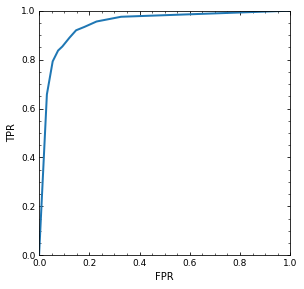

In [11]:
prob_norm = prob / prob.sum(axis=1,keepdims=True)
TPR = []
FPR = []
for threshold_d in np.arange(11)*0.1:
    bool_gt = data_test['label']
    bool_es = (prob[:,1]>threshold_d)
    size_eval = data_test.shape[0]

    bool_dd = bool_gt*bool_es
    bool_ss = (1-bool_gt)*(1-bool_es)
    bool_ds = bool_gt*(1-bool_es)
    bool_sd = (1-bool_gt)*bool_es
    TP = np.sum(bool_dd)/float(size_eval)
    TN = np.sum(bool_ss)/float(size_eval)
    FP = np.sum(bool_sd)/float(size_eval)
    FN = np.sum(bool_ds)/float(size_eval)
    TPR.append(1. * TP / (TP+FN))
    FPR.append(1. * FP / (FP+TN))
plt.plot(FPR, TPR)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### check in validation dataset

- clean validation: remove repeated data points.

In [6]:
with open(os.path.join(dsc.FLAGS.model_dir,'checkpoint')) as f:
    mid = f.readline().split('/')
    mid = mid[-2]+'_'+mid[-1][:-2]

In [7]:
data_valid = np.load('/nfs/P100/DSC/data/1218/valid.npy')
clean_inds = np.unique(data_valid['obsid'],return_index=True)[1]
data_valid_cleaned = data_valid[clean_inds]

In [8]:
#data_valid_mean = data_valid_cleaned['flux'].mean(axis=1)
#data_valid_cleaned['flux'] = data_valid_cleaned['flux'] - data_valid_mean[:,None]*np.ones([data_valid_mean.shape[0],4000])
loss, prob = dsc.eval(data_valid_cleaned['flux_norm'], data_valid_cleaned['label'])

float32 (6410, 4801)
int32 (6410,)
loop number: 51
INFO:tensorflow:Tensor("Placeholder:0", shape=(?, 4801), dtype=float32)
INFO:tensorflow:==========ResNet_sigmoid==========
INFO:tensorflow:load variable from /nfs/P100/DSC/model/ResNN_329/ResNN4-4999
INFO:tensorflow:Restoring parameters from /nfs/P100/DSC/model/ResNN_329/ResNN4-4999


100%|██████████| 51/51 [00:02<00:00, 17.30it/s]


0.41274354
d -> d 0.048205928237129485
s -> s 0.8246489859594384
d -> s 0.005616224648985959
s -> d 0.12152886115444618


/home/mtx/local/anaconda2/envs/tf1.5/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


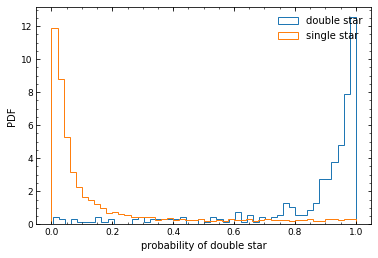

In [11]:
print loss.mean()
threshold = 0.5
bool_gt = data_valid_cleaned['label']
bool_es = prob[:,1]>threshold
size_eval = data_valid_cleaned.shape[0]
bool_dd = bool_gt*bool_es
bool_ss = (1-bool_gt)*(1-bool_es)
bool_ds = bool_gt*(1-bool_es)
bool_sd = (1-bool_gt)*bool_es
print 'd -> d', np.sum(bool_dd)/float(size_eval)  # d -> d
print 's -> s', np.sum(bool_ss)/float(size_eval)  # s -> s
print 'd -> s', np.sum(bool_ds)/float(size_eval)  # d -> s
print 's -> d', np.sum(bool_sd)/float(size_eval)  # s -> d
plt.hist(prob[bool_gt==1][:,1], 50, normed=True, histtype='step', label='double star')
plt.hist(prob[bool_gt==0][:,1], 50, normed=True, histtype='step', label='single star')
plt.xlabel('probability of double star')
plt.ylabel('PDF')
plt.legend()
plt.savefig('./test/%s_valid.png'%(mid))
plt.show()